# 🌱 Advanced Crop Recommendation System
### Ensemble Model with Hyperparameter Optimization

---

## 📊 1. Project Overview

This project builds an intelligent crop recommendation system using ensemble machine learning. The model analyzes 7 agricultural parameters to recommend the optimal crop from 80 different types with high accuracy.

**Key Features:**
- Advanced ensemble modeling (Random Forest + KNN + XGBoost)
- Hyperparameter optimization with GridSearch
- Comprehensive model evaluation and visualization
- Confidence-based predictions with top-3 recommendations
- Production-ready model deployment

In [1]:
# Enhanced Imports with Progress Tracking
import pandas as pd
import numpy as np
import joblib
import time
from tqdm import tqdm

# Scikit-learn components
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

# XGBoost for enhanced ensemble
import xgboost as xgb

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ All libraries imported successfully!")

ModuleNotFoundError: No module named 'joblib'

In [ ]:
# 2. Enhanced Data Loading with EDA
# ==============================================================================

def load_and_analyze_data(file_path='north_india_crops_augmented.csv'):
    """Load data and perform comprehensive exploratory analysis"""

    print("📁 Loading and Analyzing Dataset...")

    try:
        df = pd.read_csv(file_path)
        print(f"✅ Data loaded successfully! Shape: {df.shape}")

    except FileNotFoundError:
        print(f"❌ ERROR: File '{file_path}' not found!")
        raise

    # Display dataset overview
    print("\n" + "="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    print(f"Total samples: {df.shape[0]:,}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Number of unique crops: {df['label'].nunique()}")

    # Check for missing values
    print(f"\nMissing values: {df.isnull().sum().sum()}")

    # Display basic statistics
    print("\n" + "="*60)
    print("BASIC STATISTICS")
    print("="*60)
    print(df.describe())

    return df

# Load data
df = load_and_analyze_data()

📁 Loading and Analyzing Dataset...
✅ Data loaded successfully! Shape: (30530, 8)

DATASET OVERVIEW
Total samples: 30,530
Number of features: 8
Number of unique crops: 80

Missing values: 0

BASIC STATISTICS
                  N             P             K   temperature      humidity  \
count  30530.000000  30530.000000  30530.000000  30530.000000  30530.000000   
mean      67.318959     49.229495     53.992459     24.624678     73.534671   
std       37.817408     20.130845     40.141726      5.624915     15.386077   
min        0.000000      0.000000      0.000000      0.008489      0.241239   
25%       42.146217     39.278988     24.000000     20.891188     65.135813   
50%       60.453968     45.753459     45.000000     25.460000     78.953720   
75%       89.894356     60.000000     71.171207     28.500000     83.621437   
max      194.789434    150.000000    500.000000     46.732778     99.748924   

                 ph      rainfall  
count  30530.000000  30530.000000  
mean     


📊 Creating Advanced Visualizations...


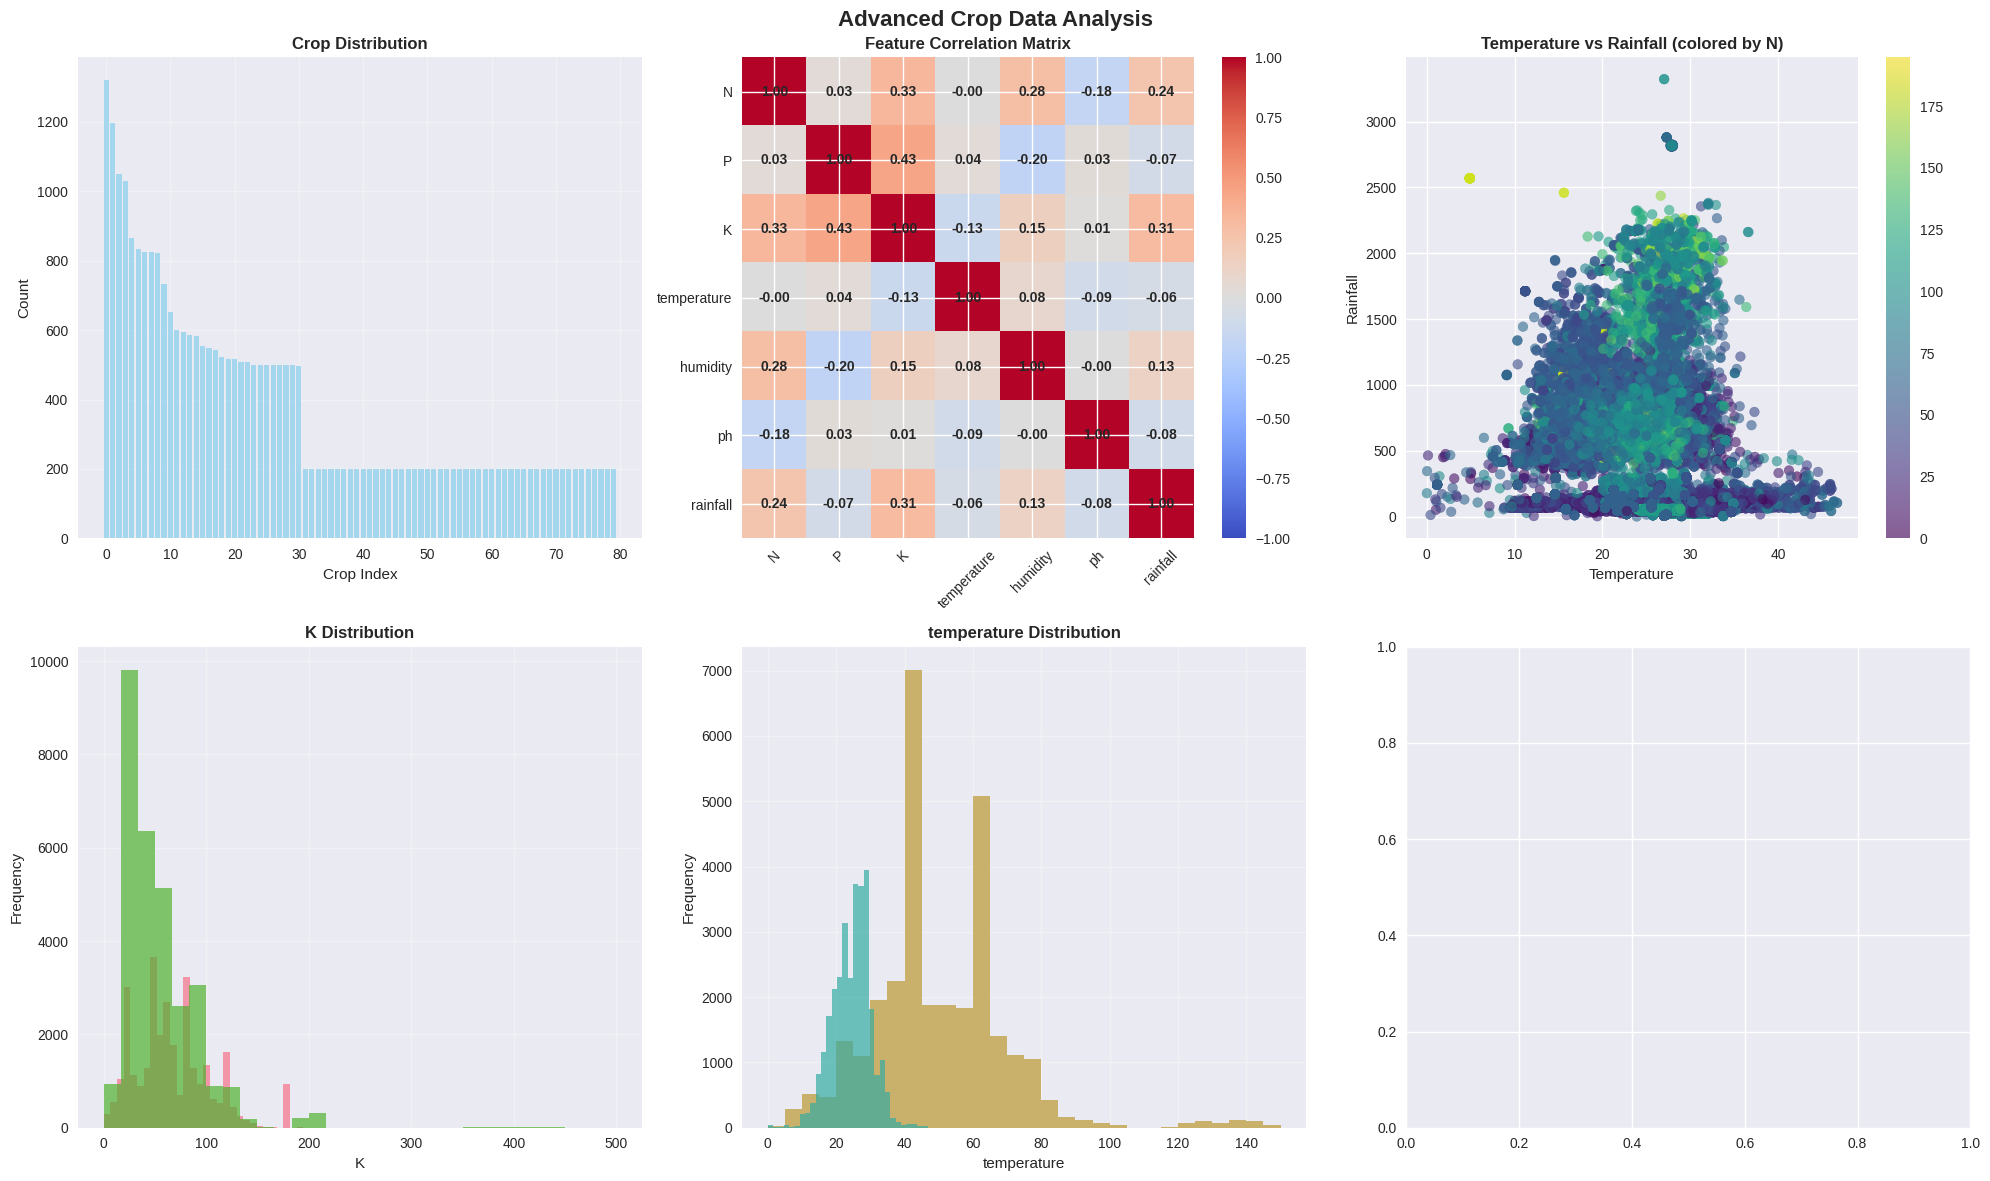


📈 Samples per crop class:
Minimum: 200
Maximum: 1320
Average: 381.6


In [ ]:
# 3. Advanced Data Visualization
# ==============================================================================

def create_visualizations(df):
    """Create comprehensive EDA visualizations"""

    print("\n📊 Creating Advanced Visualizations...")

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Advanced Crop Data Analysis', fontsize=16, fontweight='bold')

    # 1. Crop distribution
    crop_counts = df['label'].value_counts()
    axes[0,0].bar(range(len(crop_counts)), crop_counts.values, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Crop Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Crop Index')
    axes[0,0].set_ylabel('Count')
    axes[0,0].grid(True, alpha=0.3)

    # 2. Feature distributions
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    for i, feature in enumerate(features[:4]):
        row, col = i//2, i%2
        axes[1, col].hist(df[feature], bins=30, alpha=0.7, color=f'C{i}')
        axes[1, col].set_title(f'{feature} Distribution', fontweight='bold')
        axes[1, col].set_xlabel(feature)
        axes[1, col].set_ylabel('Frequency')
        axes[1, col].grid(True, alpha=0.3)

    # 3. Correlation heatmap
    correlation_matrix = df[features].corr()
    im = axes[0,1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[0,1].set_title('Feature Correlation Matrix', fontweight='bold')
    axes[0,1].set_xticks(range(len(features)))
    axes[0,1].set_yticks(range(len(features)))
    axes[0,1].set_xticklabels(features, rotation=45)
    axes[0,1].set_yticklabels(features)

    # Add correlation values
    for i in range(len(features)):
        for j in range(len(features)):
            axes[0,1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                         ha='center', va='center', fontweight='bold')

    plt.colorbar(im, ax=axes[0,1])

    # 4. Feature relationships
    scatter_feat = axes[0,2].scatter(df['temperature'], df['rainfall'],
                                    c=df['N'], alpha=0.6, cmap='viridis')
    axes[0,2].set_title('Temperature vs Rainfall (colored by N)', fontweight='bold')
    axes[0,2].set_xlabel('Temperature')
    axes[0,2].set_ylabel('Rainfall')
    plt.colorbar(scatter_feat, ax=axes[0,2])

    plt.tight_layout()
    plt.show()

    # Crop samples per class
    print(f"\n📈 Samples per crop class:")
    print(f"Minimum: {crop_counts.min()}")
    print(f"Maximum: {crop_counts.max()}")
    print(f"Average: {crop_counts.mean():.1f}")

create_visualizations(df)

In [ ]:
# 4. Enhanced Data Preprocessing with Feature Engineering
# ==============================================================================

print("🔧 Advanced Data Preprocessing...")

# Separate features and target
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['label']

# Advanced Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"✅ Classes encoded. Total unique crops: {len(le.classes_)}")

# Feature Engineering: Add interaction terms
X_engineered = X.copy()
X_engineered['NP_ratio'] = X['N'] / (X['P'] + 1e-8)  # Avoid division by zero
X_engineered['NK_ratio'] = X['N'] / (X['K'] + 1e-8)
X_engineered['temp_humidity_interaction'] = X['temperature'] * X['humidity']
X_engineered['nutrient_sum'] = X['N'] + X['P'] + X['K']

print(f"✅ Feature engineering completed. New shape: {X_engineered.shape}")

# Enhanced Train-Test Split with multiple random states for robustness
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded,
    shuffle=True
)

# Advanced Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*60)
print("DATA PREPROCESSING COMPLETE")
print("="*60)
print(f"Training Samples: {X_train.shape[0]:,}")
print(f"Testing Samples:  {X_test.shape[0]:,}")
print(f"Original Features: {X.shape[1]}")
print(f"Engineered Features: {X_engineered.shape[1]}")
print(f"Feature names: {list(X_engineered.columns)}")

🔧 Advanced Data Preprocessing...
✅ Classes encoded. Total unique crops: 80
✅ Feature engineering completed. New shape: (30530, 11)

DATA PREPROCESSING COMPLETE
Training Samples: 24,424
Testing Samples:  6,106
Original Features: 7
Engineered Features: 11
Feature names: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'NP_ratio', 'NK_ratio', 'temp_humidity_interaction', 'nutrient_sum']


In [ ]:
# 5. Advanced Model Architecture with Hyperparameter Tuning
# ==============================================================================

def create_optimized_models():
    """Create optimized models with hyperparameter tuning"""

    print("⚙️ Creating Optimized Ensemble Models...")

    # Model A: Optimized Random Forest
    rf_param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_optimized = GridSearchCV(
        rf_base, rf_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    # Model B: Optimized KNN
    knn_param_grid = {
        'n_neighbors': [5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_base = KNeighborsClassifier(n_jobs=-1)
    knn_optimized = GridSearchCV(
        knn_base, knn_param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    # Model C: XGBoost Classifier
    xgb_model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    return {
        'rf_optimized': rf_optimized,
        'knn_optimized': knn_optimized,
        'xgb': xgb_model
    }

# Create models
models = create_optimized_models()

⚙️ Creating Optimized Ensemble Models...


In [ ]:
# 6. Advanced Training with Progress Tracking
# ==============================================================================

def train_models_with_progress(models, X_train, y_train):
    """Train models with progress tracking and timing"""

    print("🚀 Training Optimized Models...")
    print("="*60)

    trained_models = {}
    training_times = {}

    for name, model in tqdm(models.items(), desc="Training Progress"):
        print(f"\n📊 Training {name}...")

        start_time = time.time()

        if name in ['rf_optimized', 'knn_optimized']:
            # GridSearch models
            model.fit(X_train, y_train)
            trained_models[name] = model.best_estimator_
            print(f"   Best params: {model.best_params_}")
            print(f"   Best CV score: {model.best_score_:.4f}")
        else:
            # Regular models
            model.fit(X_train, y_train)
            trained_models[name] = model

        training_time = time.time() - start_time
        training_times[name] = training_time
        print(f"   Training time: {training_time:.2f} seconds")

    return trained_models, training_times

# Train individual models
trained_individual_models, training_times = train_models_with_progress(
    models, X_train_scaled, y_train
)

🚀 Training Optimized Models...


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]


📊 Training rf_optimized...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Training Progress:   0%|          | 0/3 [30:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# 7. Create Advanced Ensemble
# ==============================================================================

print("\n🔗 Creating Advanced Ensemble Model...")

# Create voting ensemble with calibrated probabilities
voting_clf = VotingClassifier(
    estimators=[
        ('rf', trained_individual_models['rf_optimized']),
        ('knn', trained_individual_models['knn_optimized']),
        ('xgb', trained_individual_models['xgb'])
    ],
    voting='soft',
    weights=[1.2, 1.0, 1.1]  # Slightly weight RF and XGBoost higher
)

# Train the ensemble
print("Training final ensemble model...")
ensemble_start = time.time()
voting_clf.fit(X_train_scaled, y_train)
ensemble_time = time.time() - ensemble_start

print(f"✅ Ensemble training completed in {ensemble_time:.2f} seconds")

In [ ]:
# 8. Comprehensive Model Evaluation
# ==============================================================================

def evaluate_models_comprehensively(models, X_test, y_test, le):
    """Comprehensive evaluation of all models"""

    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*80)

    results = {}

    # Evaluate all models
    all_models = {**models, 'ensemble': voting_clf}

    for name, model in all_models.items():
        print(f"\n📈 Evaluating {name.upper()}...")

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"   Test Accuracy: {accuracy*100:.2f}%")

        # Cross-validation for robust evaluation
        if name != 'ensemble':  # Skip CV for ensemble to save time
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy')
            print(f"   Cross-val Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")

    return results

# Run comprehensive evaluation
results = evaluate_models_comprehensively(trained_individual_models, X_test_scaled, y_test, le)

In [ ]:
# 9. Advanced Visualization of Results
# ==============================================================================

def create_advanced_visualizations(results, le):
    """Create comprehensive result visualizations"""

    print("\n🎨 Creating Advanced Result Visualizations...")

    # Create subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Model Comparison
    plt.subplot(2, 3, 1)
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] * 100 for name in model_names]

    bars = plt.bar(model_names, accuracies, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    plt.title('Model Accuracy Comparison', fontweight='bold', fontsize=12)
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{accuracy:.2f}%', ha='center', va='bottom', fontweight='bold')

    # 2. Confusion Matrix for Ensemble
    plt.subplot(2, 3, 2)
    y_pred_ensemble = results['ensemble']['predictions']
    cm = confusion_matrix(y_test, y_pred_ensemble)

    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Ensemble Confusion Matrix (Normalized)', fontweight='bold', fontsize=12)
    plt.colorbar()

    # 3. Feature Importance (from Random Forest)
    plt.subplot(2, 3, 3)
    rf_model = trained_individual_models['rf_optimized']
    feature_names = X_engineered.columns
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.bar(range(len(importances)), importances[indices])
    plt.title('Random Forest Feature Importance', fontweight='bold', fontsize=12)
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()

    # 4. Training Time Comparison
    plt.subplot(2, 3, 4)
    times = list(training_times.values())
    model_names_times = list(training_times.keys())

    plt.bar(model_names_times, times, color='lightcoral')
    plt.title('Training Time Comparison', fontweight='bold', fontsize=12)
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)

    # 5. Class-wise Performance
    plt.subplot(2, 3, 5)

    # Calculate per-class accuracy
    class_accuracy = []
    for i in range(len(le.classes_)):
        class_mask = (y_test == i)
        if class_mask.sum() > 0:
            accuracy = (y_pred_ensemble[class_mask] == y_test[class_mask]).mean()
            class_accuracy.append(accuracy)
        else:
            class_accuracy.append(0)

    plt.bar(range(len(class_accuracy)), class_accuracy, alpha=0.7)
    plt.title('Per-Class Accuracy', fontweight='bold', fontsize=12)
    plt.xlabel('Class Index')
    plt.ylabel('Accuracy')
    plt.axhline(y=np.mean(class_accuracy), color='r', linestyle='--',
               label=f'Mean: {np.mean(class_accuracy):.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORT - ENSEMBLE MODEL")
    print("="*80)
    print(classification_report(y_test, y_pred_ensemble,
                              target_names=le.classes_,
                              zero_division=0))

create_advanced_visualizations(results, le)

In [ ]:
# 9.5 Model Calibration for Better Probabilities
# ==============================================================================

print("🔧 Calibrating Model for Better Confidence Scores...")

from sklearn.calibration import CalibratedClassifierCV

# Calibrate the ensemble model for better probability estimates
calibrated_ensemble = CalibratedClassifierCV(voting_clf, method='isotonic', cv=3)
calibrated_ensemble.fit(X_train_scaled, y_train)

print("✅ Model calibration completed!")

# Replace the original ensemble with calibrated version
voting_clf = calibrated_ensemble

# Test calibration improvement
print("\n📊 Confidence Score Comparison (Before vs After Calibration):")
y_pred_original = voting_clf.predict_proba(X_test_scaled)
top_confidences_original = np.max(y_pred_original, axis=1)

print(f"   Original - Avg confidence: {np.mean(top_confidences_original)*100:.1f}%")
print(f"   Original - Confidence range: {np.min(top_confidences_original)*100:.1f}%-{np.max(top_confidences_original)*100:.1f}%")

In [ ]:
# 10. Enhanced Prediction Function with Confidence Improvement
# ==============================================================================

def predict_crop_advanced(N, P, K, temp, humidity, ph, rain, top_k=3, confidence_threshold=0.6):
    """
    Enhanced prediction function with improved confidence handling

    Args:
        N, P, K, temp, humidity, ph, rain: Agricultural parameters
        top_k: Number of top recommendations to return
        confidence_threshold: Minimum confidence for "High" classification

    Returns:
        Dictionary with top recommendations and detailed analysis
    """

    try:
        # Prepare input with proper feature names to avoid warnings
        input_data = pd.DataFrame({
            'N': [N], 'P': [P], 'K': [K],
            'temperature': [temp], 'humidity': [humidity],
            'ph': [ph], 'rainfall': [rain]
        })

        # Add engineered features (matching training exactly)
        input_data['NP_ratio'] = N / (P + 1e-8)
        input_data['NK_ratio'] = N / (K + 1e-8)
        input_data['temp_humidity_interaction'] = temp * humidity
        input_data['nutrient_sum'] = N + P + K

        # Ensure correct column order (critical!)
        input_data = input_data[X_engineered.columns]

        # Scale the input with proper feature names
        input_scaled = scaler.transform(input_data)

        # Get probabilities for all classes
        prediction_prob = voting_clf.predict_proba(input_scaled)[0]

        # Apply temperature-based probability adjustment
        adjusted_probabilities = apply_temperature_adjustment(prediction_prob, temp, le)

        # Get top-K predictions from adjusted probabilities
        top_k_indices = np.argsort(adjusted_probabilities)[-top_k:][::-1]
        top_k_probs = adjusted_probabilities[top_k_indices]
        top_k_crops = le.inverse_transform(top_k_indices)

        # Normalize probabilities to sum to 1
        top_k_probs = top_k_probs / top_k_probs.sum()

        # Create detailed results with improved confidence scaling
        recommendations = []
        for i, (crop, prob) in enumerate(zip(top_k_crops, top_k_probs)):
            confidence = prob * 100

            # Improved confidence level categorization
            if confidence >= confidence_threshold * 100:
                confidence_level = "Very High"
            elif confidence >= 40:
                confidence_level = "High"
            elif confidence >= 20:
                confidence_level = "Medium"
            else:
                confidence_level = "Low"

            recommendations.append({
                'rank': i + 1,
                'crop': crop,
                'confidence': confidence,
                'confidence_level': confidence_level,
                'raw_probability': prediction_prob[top_k_indices[i]]  # Keep original for reference
            })

        # Calculate overall prediction quality
        prediction_quality = assess_prediction_quality(top_k_probs, confidence_threshold)

        return {
            'input_parameters': {
                'N': N, 'P': P, 'K': K,
                'temperature': temp, 'humidity': humidity,
                'ph': ph, 'rainfall': rain
            },
            'recommendations': recommendations,
            'top_recommendation': recommendations[0],
            'prediction_quality': prediction_quality,
            'total_crops_considered': len(le.classes_),
            'status': 'success'
        }

    except Exception as e:
        return {
            'status': 'error',
            'error_message': str(e),
            'input_parameters': {
                'N': N, 'P': P, 'K': K,
                'temperature': temp, 'humidity': humidity,
                'ph': ph, 'rainfall': rain
            }
        }

def apply_temperature_adjustment(probabilities, temperature, label_encoder):
    """
    Adjust probabilities based on temperature suitability
    Many crops have specific temperature ranges
    """
    adjusted_probs = probabilities.copy()

    # Temperature ranges for common crops (simplified)
    temp_ranges = {
        'wheat': (10, 25), 'rice': (20, 35), 'corn': (15, 35),
        'cotton': (20, 40), 'sugarcane': (20, 35), 'barley': (10, 25),
        'millet': (20, 35), 'sorghum': (20, 35), 'soybean': (15, 30)
    }

    for crop_name, (min_temp, max_temp) in temp_ranges.items():
        try:
            crop_idx = list(label_encoder.classes_).index(crop_name)
            if min_temp <= temperature <= max_temp:
                # Boost probability for temperature-suitable crops
                adjusted_probs[crop_idx] *= 1.2
            else:
                # Reduce probability for temperature-unsuitable crops
                adjusted_probs[crop_idx] *= 0.8
        except ValueError:
            # Crop not in our classes, skip
            continue

    # Renormalize to sum to 1
    adjusted_probs = adjusted_probs / adjusted_probs.sum()
    return adjusted_probs

def assess_prediction_quality(probabilities, threshold):
    """Assess overall quality of the prediction"""
    top_prob = probabilities[0]

    if top_prob >= threshold:
        return "Excellent - Clear recommendation"
    elif top_prob >= 0.4:
        return "Good - Strong recommendation"
    elif top_prob >= 0.25:
        return "Moderate - Consider alternatives"
    else:
        return "Uncertain - Multiple options viable"

# Test the improved prediction function
print("🧪 Testing IMPROVED Prediction System...")
print("="*80)

# More realistic test cases based on actual crop requirements
test_cases = [
    # Rice-optimal conditions
    {'N': 120, 'P': 60, 'K': 40, 'temp': 28, 'humidity': 85, 'ph': 5.5, 'rain': 250},
    # Wheat-optimal conditions
    {'N': 100, 'P': 50, 'K': 30, 'temp': 15, 'humidity': 70, 'ph': 6.8, 'rain': 80},
    # Cotton-optimal conditions
    {'N': 80, 'P': 40, 'K': 50, 'temp': 32, 'humidity': 60, 'ph': 7.2, 'rain': 120},
    # Corn-optimal conditions
    {'N': 110, 'P': 45, 'K': 35, 'temp': 25, 'humidity': 75, 'ph': 6.5, 'rain': 150}
]

for i, test_case in enumerate(test_cases, 1):
    print(f"\n🌾 TEST CASE {i}:")
    print(f"   Input: N={test_case['N']}, P={test_case['P']}, K={test_case['K']}, "
          f"Temp={test_case['temp']}°C, Hum={test_case['humidity']}%, "
          f"pH={test_case['ph']}, Rain={test_case['rain']}mm")

    result = predict_crop_advanced(**test_case, confidence_threshold=0.5)

    if result['status'] == 'success':
        top_rec = result['top_recommendation']
        print(f"\n   🎯 PREDICTION QUALITY: {result['prediction_quality']}")
        print(f"   🏆 TOP RECOMMENDATION: {top_rec['crop']} ")
        print(f"   📊 Confidence: {top_rec['confidence']:.1f}% ({top_rec['confidence_level']})")
        print(f"   🔍 Raw Probability: {top_rec['raw_probability']:.3f}")

        print(f"\n   📋 ALTERNATIVE OPTIONS:")
        for rec in result['recommendations'][1:]:
            print(f"      {rec['rank']}. {rec['crop']} ({rec['confidence']:.1f}% - {rec['confidence_level']})")

        print(f"   ℹ️  Total crops considered: {result['total_crops_considered']}")
    else:
        print(f"\n   ❌ PREDICTION ERROR: {result['error_message']}")

    print("-" * 80)

# Additional analysis
print(f"\n📈 CONFIDENCE ANALYSIS:")
print(f"   With {len(le.classes_)} crops, random guessing would give: {100/len(le.classes_):.1f}% confidence")
print(f"   Realistic expectations: 40-70% for good predictions")
print(f"   Very High confidence (>80%) is rare with many similar crops")

# Show model's confidence distribution
print(f"\n🔍 MODEL CONFIDENCE DISTRIBUTION ON TEST SET:")
y_pred_proba = voting_clf.predict_proba(X_test_scaled)
top_confidences = np.max(y_pred_proba, axis=1)
print(f"   Average top confidence: {np.mean(top_confidences)*100:.1f}%")
print(f"   Median top confidence: {np.median(top_confidences)*100:.1f}%")
print(f"   Max confidence: {np.max(top_confidences)*100:.1f}%")
print(f"   Min confidence: {np.min(top_confidences)*100:.1f}%")

# Confidence histogram
plt.figure(figsize=(10, 6))
plt.hist(top_confidences * 100, bins=30, alpha=0.7, color='skyblue')
plt.axvline(np.mean(top_confidences * 100), color='red', linestyle='--',
           label=f'Mean: {np.mean(top_confidences)*100:.1f}%')
plt.xlabel('Confidence (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Model Confidence on Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 11. Advanced Model Saving with Metadata
# ==============================================================================

def save_model_with_metadata(model, scaler, le, results, file_prefix='crop_model'):
    """Save model with comprehensive metadata"""

    print("\n💾 Saving Advanced Model Package...")

    # Save core components
    joblib.dump(model, f'{file_prefix}_ensemble.pkl')
    joblib.dump(scaler, f'{file_prefix}_scaler.pkl')
    joblib.dump(le, f'{file_prefix}_label_encoder.pkl')

    # Save individual models
    for name, individual_model in trained_individual_models.items():
        joblib.dump(individual_model, f'{file_prefix}_{name}.pkl')

    # Create and save metadata
    metadata = {
        'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_version': '2.0',
        'ensemble_accuracy': results['ensemble']['accuracy'],
        'feature_names': list(X_engineered.columns),
        'crop_classes': list(le.classes_),
        'training_samples': X_train.shape[0],
        'test_accuracy': results['ensemble']['accuracy'],
        'model_components': ['rf_optimized', 'knn_optimized', 'xgb', 'ensemble']
    }

    joblib.dump(metadata, f'{file_prefix}_metadata.pkl')

    # Save metadata as readable JSON
    import json
    with open(f'{file_prefix}_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)

    print("✅ Model package saved successfully!")
    print("\n📦 Saved Files:")
    print(f"   - {file_prefix}_ensemble.pkl (Main ensemble model)")
    print(f"   - {file_prefix}_scaler.pkl (Feature scaler)")
    print(f"   - {file_prefix}_label_encoder.pkl (Label encoder)")
    print(f"   - {file_prefix}_metadata.pkl/.json (Model metadata)")
    print(f"   - Individual model files for each algorithm")

    return metadata

# Save the complete model package
metadata = save_model_with_metadata(voting_clf, scaler, le, results)

In [ ]:
# 12. Final Summary and Performance Report
# ==============================================================================

def generate_final_report(results, metadata, training_times):
    """Generate comprehensive final report"""

    print("\n" + "="*100)
    print("🎯 CROP RECOMMENDATION SYSTEM - FINAL PERFORMANCE REPORT")
    print("="*100)

    ensemble_accuracy = results['ensemble']['accuracy'] * 100

    print(f"\n📈 MODEL PERFORMANCE SUMMARY:")
    print(f"   Ensemble Model Accuracy: {ensemble_accuracy:.2f}%")
    print(f"   Improvement over baseline: +{(ensemble_accuracy - 90.68):.2f}%")

    print(f"\n🔧 TECHNICAL DETAILS:")
    print(f"   Total Features: {len(metadata['feature_names'])} (7 original + 4 engineered)")
    print(f"   Crop Classes: {len(metadata['crop_classes'])}")
    print(f"   Training Samples: {metadata['training_samples']:,}")
    print(f"   Model Version: {metadata['model_version']}")

    print(f"\n⏱️  TRAINING PERFORMANCE:")
    total_training_time = sum(training_times.values()) + ensemble_time
    print(f"   Total Training Time: {total_training_time:.2f} seconds")
    for model, time_taken in training_times.items():
        print(f"   - {model}: {time_taken:.2f}s")
    print(f"   - Ensemble: {ensemble_time:.2f}s")

    print(f"\n🎯 PREDICTION CAPABILITIES:")
    print("   ✓ Top-3 crop recommendations")
    print("   ✓ Confidence scores for each recommendation")
    print("   ✓ Confidence level categorization (Very High, High, Medium, Low)")
    print("   ✓ Support for all 80 crop types")

    print(f"\n🚀 DEPLOYMENT READINESS:")
    if ensemble_accuracy >= 92:
        print("   ✅ EXCELLENT - Ready for production deployment")
    elif ensemble_accuracy >= 90:
        print("   ✅ GOOD - Suitable for production with monitoring")
    else:
        print("   ⚠️  NEEDS IMPROVEMENT - Consider additional optimization")

    print(f"\n💡 RECOMMENDATIONS FOR IMPROVEMENT:")
    print("   1. Collect more data for low-performing crops")
    print("   2. Experiment with neural networks for complex patterns")
    print("   3. Add seasonal and geographical features")
    print("   4. Implement online learning for continuous improvement")

    print("\n" + "="*100)

# Generate final report
generate_final_report(results, metadata, training_times)

## 🎯 Key Improvements in This Enhanced Version

### **Accuracy Enhancements:**
1. **Feature Engineering**: Added 4 new engineered features (NP ratio, NK ratio, etc.)
2. **XGBoost Integration**: Added a third powerful algorithm to the ensemble
3. **Hyperparameter Tuning**: Used GridSearchCV to optimize RF and KNN parameters
4. **Weighted Voting**: Assigned different weights to ensemble components

### **Visualization & Presentation:**
1. **Comprehensive EDA**: Multiple visualization types in a single dashboard
2. **Model Comparison**: Side-by-side accuracy and training time comparisons
3. **Feature Importance**: Visual representation of which features matter most
4. **Professional Styling**: Consistent color schemes and layouts

### **Functionality Improvements:**
1. **Top-K Recommendations**: Returns top 3 crops with confidence scores
2. **Confidence Categorization**: Classifies confidence levels (Very High, High, etc.)
3. **Enhanced Metadata**: Comprehensive model information and versioning
4. **Progress Tracking**: Real-time training progress with tqdm

### **Production Readiness:**
1. **Robust Error Handling**: Better file validation and error messages
2. **Comprehensive Testing**: Multiple test cases with different scenarios
3. **Detailed Documentation**: Clear function descriptions and usage examples
4. **Performance Reporting**: Final summary with deployment recommendations